In [1]:
# Author: Lichirui Zhang (lz2627), Columbia University
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import subprocess
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag

from basenji import dataset, dna_io, seqnn
import pickle
import datetime

2.8.0


## Data

In [3]:
### load params, specify model ###

# model_dir = './'
# params_file = model_dir+'params.json'
# model_file  = model_dir+'model_best.h5'
# with open(params_file) as params_open:
#     params = json.load(params_open)
#     params_model = params['model']
#     params_train = params['train']

# seqnn_model = seqnn.SeqNN(params_model)
## restore model ###
## note: run %%bash get_model.sh 
## if you have not already downloaded the model
# seqnn_model.restore(model_file)
# print('successfully loaded')

In [4]:
### names of targets ###
data_dir =   './data/'

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

In [5]:
sequences = pd.read_csv(data_dir+'sequences.bed', sep='\t', names=['chr','start','stop','type'])
sequences_test = sequences.iloc[sequences['type'].values=='test']
sequences_test.reset_index(inplace=True, drop=True)

In [6]:
# test_data = dataset.SeqDataset(data_dir, 'test', batch_size=8)
# test_inputs, test_targets = test_data.numpy(return_inputs=True, return_outputs=True)

# train_data = dataset.SeqDataset(data_dir, 'train', batch_size=8)
# train_inputs, train_targets = train_data.numpy(return_inputs=True, return_outputs=True)

# valid_data = dataset.SeqDataset(data_dir, 'valid', batch_size=8)
# valid_inputs, valid_targets = valid_data.numpy(return_inputs=True, return_outputs=True)

In [7]:
DEBUG = 0

if not DEBUG:
    with open("./train_data.pkl", 'rb') as f:
        train_inputs, train_targets = pickle.load(f)
    with open("./train_atac_seq_input.pkl", 'rb') as f:
        train_atac_seq = pickle.load(f)

    with open("./valid_data.pkl", 'rb') as f:
        valid_inputs, valid_targets = pickle.load(f)
    with open("./valid_atac_seq_input.pkl", 'rb') as f:
        valid_atac_seq = pickle.load(f)

    with open("./test_data.pkl", 'rb') as f:
        test_inputs, test_targets = pickle.load(f)
    with open("./test_atac_seq_input.pkl", 'rb') as f:
        test_atac_seq = pickle.load(f)

else:
    with open("./test_data.pkl", 'rb') as f:
        train_inputs, train_targets = pickle.load(f)
    with open("./test_atac_seq_input.pkl", 'rb') as f:
        train_atac_seq = pickle.load(f)

    with open("./test_data.pkl", 'rb') as f:
        valid_inputs, valid_targets = pickle.load(f)
    with open("./test_atac_seq_input.pkl", 'rb') as f:
        valid_atac_seq = pickle.load(f)

    with open("./test_data.pkl", 'rb') as f:
        test_inputs, test_targets = pickle.load(f)
    with open("./test_atac_seq_input.pkl", 'rb') as f:
        test_atac_seq = pickle.load(f)

In [8]:
# # ATAC-seq data
# atac_seq = pd.read_csv("Sample_0902.bed", delim_whitespace=True)

In [9]:
# # prepare a dictionary for each chromosome atac-seq signal
# atac_seq_ranges = {}
# for chromosome in np.unique(atac_seq['chr'].values):
#     atac_seq_data = atac_seq[atac_seq['chr'] == chromosome]
#     atac_seq_signal = []
#     for j in range(atac_seq_data.shape[0]):
#         atac_start = atac_seq_data['start'].iloc[j]
#         atac_end = atac_seq_data['end'].iloc[j]
#         atac_seq_signal += list(range(atac_start, atac_end))
    
#     atac_seq_ranges[chromosome] = atac_seq_signal    

In [10]:
# sequences_test = sequences.iloc[sequences['type'].values=='test']
# sequences_test.reset_index(inplace=True, drop=True)

# test_atac_seq_labels = []
# for i in range(sequences_test.shape[0]):
#     if i%10 == 0:
#         print(i/sequences_test.shape[0]*100)
#     curr_chr = sequences_test['chr'].iloc[i]
#     start = sequences_test['start'].iloc[i]
#     end = sequences_test['stop'].iloc[i]
#     seq_range = list(range(start, end))
    
#     # find intersections
#     atac_seq_signal = atac_seq_ranges[curr_chr]
#     intersection = np.nonzero(np.in1d(seq_range,atac_seq_signal))[0]
    

#     atac_seq_label = np.zeros((end-start))
#     atac_seq_label[intersection] = 1.
#     test_atac_seq_labels.append(atac_seq_label)
# with open("./test_atac_seq_input.pkl", "wb") as f:
#     pickle.dump(test_atac_seq_labels, f)

In [11]:
# sequences_valid = sequences.iloc[sequences['type'].values=='valid']
# sequences_valid.reset_index(inplace=True, drop=True)

# valid_atac_seq_labels = []
# for i in range(sequences_valid.shape[0]):
#     if i%10 == 0:
#         print(i/sequences_valid.shape[0]*100)
#     curr_chr = sequences_valid['chr'].iloc[i]
#     start = sequences_valid['start'].iloc[i]
#     end = sequences_valid['stop'].iloc[i]
#     seq_range = list(range(start, end))
    
#     # find intersections
#     atac_seq_signal = atac_seq_ranges[curr_chr]
#     intersection = np.nonzero(np.in1d(seq_range,atac_seq_signal))[0]
    

#     atac_seq_label = np.zeros((end-start))
#     atac_seq_label[intersection] = 1.
#     valid_atac_seq_labels.append(atac_seq_label)
# with open("./valid_atac_seq_input.pkl", "wb") as f:
#     pickle.dump(valid_atac_seq_labels, f)

In [12]:
# sequences_train = sequences.iloc[sequences['type'].values=='train']
# sequences_train.reset_index(inplace=True, drop=True)

# train_atac_seq_labels = []
# for i in range(sequences_train.shape[0]):
#     if i%10 == 0:
#         print(i/sequences_train.shape[0]*100)
#     curr_chr = sequences_train['chr'].iloc[i]
#     start = sequences_train['start'].iloc[i]
#     end = sequences_train['stop'].iloc[i]
#     seq_range = list(range(start, end))
    
#     # find intersections
#     atac_seq_signal = atac_seq_ranges[curr_chr]
#     intersection = np.nonzero(np.in1d(seq_range,atac_seq_signal))[0]
    

#     atac_seq_label = np.zeros((end-start))
#     atac_seq_label[intersection] = 1.
#     train_atac_seq_labels.append(atac_seq_label)
# with open("./train_atac_seq_input.pkl", "wb") as f:
#     pickle.dump(train_atac_seq_labels, f)

In [13]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE_PER_REPLICA = 2
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
def train_generator():
    for data, atac_seq, targets in zip(train_inputs, train_atac_seq, train_targets):
        yield {"data": data, "atac_seq": atac_seq, "targets": targets}

        
train_dataset = tf.data.Dataset.from_generator(
        train_generator,
        output_types=({"data": tf.float32, "atac_seq": tf.int32, "targets": tf.float32}),
        output_shapes=({"data": [1048576, 4], "atac_seq":[1048576], "targets": [99681,5]}),
    ).batch(
        batch_size=BATCH_SIZE,
        drop_remainder=True)


def valid_generator():
    for data, atac_seq, targets in zip(valid_inputs, valid_atac_seq, valid_targets):
        yield {"data": data, "atac_seq": atac_seq, "targets": targets}

        
valid_dataset = tf.data.Dataset.from_generator(
        valid_generator,
        output_types=({"data": tf.float32, "atac_seq": tf.int32, "targets": tf.float32}),
        output_shapes=({"data": [1048576, 4], "atac_seq":[1048576], "targets": [99681,5]}),
    ).batch(
        batch_size=BATCH_SIZE,
        drop_remainder=True)

def test_generator():
    for data, atac_seq, targets in zip(test_inputs, test_atac_seq, test_targets):
        yield {"data": data, "atac_seq": atac_seq, "targets": targets}

        
test_dataset = tf.data.Dataset.from_generator(
        test_generator,
        output_types=({"data": tf.float32, "atac_seq": tf.int32, "targets": tf.float32}),
        output_shapes=({"data": [1048576, 4], "atac_seq":[1048576], "targets": [99681,5]}),
    ).batch(
        batch_size=BATCH_SIZE,
        drop_remainder=True)

2022-05-02 19:03:38.428073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:03:38.432900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:03:38.434397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:03:38.435485: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2


## Model

In [14]:
from custom_models import *
from tensorflow.keras.layers import Dense, Conv2D, Activation, Dropout, Conv1D, MaxPool1D, Cropping2D

In [15]:
class Core(tf.keras.Model):
    def __init__(self, trans_1D=True, trans_2D=False, ATAC_Seq=True):
        super(Core, self).__init__()
        self.trans_1D = trans_1D
        self.trans_2D = trans_2D
        self.ATAC_Seq = ATAC_Seq
        
        ########## 1D part ############
        self.src = StochasticReverseComplement()
        self.ss = StochasticShift(shift_max=11, symmetric=True)
        self.layers_1d = []
        # downsample 1048576 to 512 using strided resnet 1d
        self.layers_1d += [tf.keras.Sequential([
                  Activation('relu'),
                  Conv1D(96, 11, padding='same', use_bias=False),
                  BatchNormalization(),
                  MaxPool1D(2, padding='same'),
                ])]
        
        # downsample
        self.layers_1d += [Residual_downsample_1D(96, 5, dropout=0.0) for i in range(10)]
        if trans_1D:
            self.pe = positional_encoding(10000, 96)
            self.layers_transformer = []
            self.layers_transformer += [EncoderLayer(d_model=96, num_heads=4, dff=2, rate=0.15) for _ in range(4)]
        # refine
        self.layers_1d_refine = []
        self.layers_1d_refine += [Residual_dilated_1D(96, 3, dilation_rate=int(np.round(1.75**(i+1))), dropout=0.4) for i in range(8)]
        
        self.layers_1d_refine += [tf.keras.Sequential([
                  Activation('relu'),
                  Conv1D(64, 5, padding='same', use_bias=False),
                  BatchNormalization(momentum=0.9265),
                ])]

        ########## 2D part ############
        # Project the 2D map
        self.one2two = OneToTwo()
        self.proj1 = tf.keras.Sequential([
                  Conv2D(48, 3, padding='same', use_bias=False),
                  BatchNormalization(momentum=0.9265),
                  Symmetrize(),
                  Activation('relu'),
                ])
        self.layers_2d = []
        self.layers_2d += [Residual_dilated_2D(48, 3, dilation_rate=int(np.round(1.75**(i+1))), dropout=0.1) for i in range(6)]
        if trans_2D:
            self.layer_transformer_2d = []
            self.layer_transformer_2d += [AxialEncoderLayer(d_model=48, num_heads=4, dff=2, rate=0.1) for _ in range(2)]
        
        ########## Prediction: 5 maps upper triangle #########
        self.upper_trig = UpperTri(diagonal_offset=2)
        self.srut = SwitchReverseTriu(diagonal_offset=2)
        self.d1 = Dense(5)
        
                
    def call(self, data):
        seq, atac_seq = data
        B = tf.shape(seq)[0]
        x, rc_flag = self.src(seq)
        x = self.ss(x)
        
        if self.ATAC_Seq:
            x = tf.concat([x, atac_seq], -1)
        for layer in self.layers_1d:
            x = layer(x) # (B, L, D)
        if self.trans_1D:
            x += self.pe[:, :x.shape[1], :]
            for layer in self.layers_transformer:
                x = layer(x) # (B, L, D)
        for layer in self.layers_1d_refine:
            x = layer(x) # (B, L, D)
        

        # 1D to 2D
        x = self.one2two(x)
        relative_pos_enc = tf.tile(tf.reshape(tf.range(x.shape[1]), (1, -1, 1)), (B, 1, 1)) # (1, L, 1)
        relative_pos_enc_2d = tf.cast(tf.abs(relative_pos_enc[:, None, :, :] - relative_pos_enc[:, :, None, :]), tf.float32)
        x = tf.concat([x, relative_pos_enc_2d], -1)
        
        # project 2D
        x = self.proj1(x) # (B, L, L, 48)
        for layer in self.layers_2d:
            x = layer(x) # (B, L, D) 
        if self.trans_2D:
            for layer in self.layer_transformer_2d:
                x = layer(x) # (B, L, D) 
        
        x = Cropping2D(cropping=((32, 32), (32, 32)))(x)
        x = (x + tf.transpose(x, [0, 2, 1, 3]))/2
        
        x = self.upper_trig(x)
        x = self.d1(x)
        x = self.srut((x, rc_flag))
        return x

## Train

In [16]:
# train
class Model(tf.keras.Model):
    def __init__(self, model):
        super(Model, self).__init__()
        self.model = model
        
    def compile(self, optimizer, loss_function):
        super(Model, self).compile()
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.test_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.train_PearsonR = PearsonR(num_targets=5)
        self.train_R2 = R2(num_targets=5)
        self.val_PearsonR = PearsonR(num_targets=5)
        self.val_R2 = R2(num_targets=5)
        self.test_PearsonR = PearsonR(num_targets=5)
        self.test_R2 = R2(num_targets=5)
            
    def train_step(self, data):
        inputs = data["data"] # (B, 1048576, 4)
        targets = data["targets"] # (B, 448*448, 5)
        atac_seq = data["atac_seq"] # (B, 1048576, 1)
        atac_seq = tf.one_hot(atac_seq, depth=2)
        
        inputs = inputs, atac_seq
                
        with tf.GradientTape() as tape:
            pred_map = self.model(inputs, training=True)
            loss = tf.reduce_mean(self.loss_function(targets, pred_map))
            
        # update parameters
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
#         gradients, _ = tf.clip_by_global_norm(gradients, 10.)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.loss_tracker.update_state(loss) # total loss
        self.train_PearsonR.update_state(targets, pred_map)
        self.train_R2.update_state(targets, pred_map)
        return {"loss": self.loss_tracker.result(), "PearsonR": self.train_PearsonR.result(), "R2": self.train_R2.result()}
    def validation_step(self, data):
        inputs = data["data"] # (B, 1048576, 4)
        targets = data["targets"] # (B, 448*448, 5)
        atac_seq = data["atac_seq"] # (B, 1048576, 1)
        atac_seq = tf.one_hot(atac_seq, depth=2)
        inputs = inputs, atac_seq
        
        pred_map = self.model(inputs, training=False)
        loss = tf.reduce_mean(self.loss_function(targets, pred_map))
        
        self.val_loss_tracker.update_state(loss) # total loss
        self.val_PearsonR.update_state(targets, pred_map)
        self.val_R2.update_state(targets, pred_map)
        return {"loss": self.val_loss_tracker.result(), "PearsonR": self.val_PearsonR.result(), "R2": self.val_R2.result()}
    def test_step(self, data):
        inputs = data["data"] # (B, 1048576, 4)
        targets = data["targets"] # (B, 448*448, 5)
        atac_seq = data["atac_seq"] # (B, 1048576, 1)
        atac_seq = tf.one_hot(atac_seq, depth=2)
        inputs = inputs, atac_seq
        
        pred_map = self.model(inputs, training=False)
        loss = tf.reduce_mean(self.loss_function(targets, pred_map))
        
        self.test_loss_tracker.update_state(loss) # total loss
        self.test_PearsonR.update_state(targets, pred_map)
        self.test_R2.update_state(targets, pred_map)
        return {"loss": self.test_loss_tracker.result(), "PearsonR": self.test_PearsonR.result(), "R2": self.test_R2.result()}

In [28]:
with strategy.scope():
    Core_model = Core(trans_1D=True, trans_2D=False, ATAC_Seq=True)
    Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
    model = Model(model=Core_model)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [29]:
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(patience=12, restore_best_weights=True, monitor='val_PearsonR', mode='max', verbose=1)
lr_reducer  = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, monitor='val_PearsonR', mode='max', verbose=1)
checkpt_dir = "checkpoints/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_checkpoint_callback = ModelCheckpoint(checkpt_dir, save_weights_only=True, monitor='val_PearsonR', mode='max', save_best_only=True, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard('./logs/', update_freq=1)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=10000, callbacks=[model_checkpoint_callback, tb_callback, early_stopping])

Epoch 1/10000


2022-05-01 12:14:43.840029: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_32"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1048576
        }
      }
      shape {
        dim {
          size: 1048576
        }
        dim {
          size: 4
        }
      }
      shape {
        dim {
          size: 99681
        }
        dim {
          size: 5
        }
  

INFO:tensorflow:batch_all_reduce: 181 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 181 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 181 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 181 all-reduces with algorithm = nccl, num_packs = 1
2022-05-01 12:15:08.153122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


   1624/Unknown - 534s 312ms/step - loss: 0.2698 - PearsonR: 0.0079 - R2: -1.1015

2022-05-01 12:23:38.492959: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_62"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1048576
        }
      }
      shape {
        dim {
          size: 1048576
        }
        dim {
          size: 4
        }
      }
      shape {
        dim {
          size: 99681
        }
        dim {
          size: 5
        }
  


Epoch 1: val_PearsonR improved from -inf to 0.09044, saving model to checkpoints/20220501-121443
1624/1624 [==============================] - 548s 320ms/step - loss: 0.2698 - PearsonR: 0.0079 - R2: -1.1010 - val_loss: 0.2197 - val_PearsonR: 0.0904 - val_R2: -0.0029
Epoch 2/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2137 - PearsonR: 0.0578 - R2: -7.1221e-04
Epoch 2: val_PearsonR improved from 0.09044 to 0.09193, saving model to checkpoints/20220501-121443
1624/1624 [==============================] - 516s 318ms/step - loss: 0.2137 - PearsonR: 0.0578 - R2: -7.1058e-04 - val_loss: 0.2180 - val_PearsonR: 0.0919 - val_R2: 0.0075
Epoch 3/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2135 - PearsonR: 0.0606 - R2: 0.0014
Epoch 3: val_PearsonR did not improve from 0.09193
1624/1624 [==============================] - 516s 318ms/step - loss: 0.2135 - PearsonR: 0.0606 - R2: 0.0014 - val_loss: 0.2179 - val_PearsonR: 0.0918 - val_R2: 0.0075
Epoch 4/10

1624/1624 [==============================] - 516s 318ms/step - loss: 0.1372 - PearsonR: 0.5880 - R2: 0.3463 - val_loss: 0.1503 - val_PearsonR: 0.5625 - val_R2: 0.3102
Epoch 24/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1353 - PearsonR: 0.5965 - R2: 0.3564
Epoch 24: val_PearsonR did not improve from 0.56247
1624/1624 [==============================] - 516s 318ms/step - loss: 0.1353 - PearsonR: 0.5965 - R2: 0.3564 - val_loss: 0.1652 - val_PearsonR: 0.5255 - val_R2: 0.2417
Epoch 25/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1331 - PearsonR: 0.6029 - R2: 0.3641
Epoch 25: val_PearsonR improved from 0.56247 to 0.56919, saving model to checkpoints/20220501-121443
1624/1624 [==============================] - 516s 318ms/step - loss: 0.1331 - PearsonR: 0.6029 - R2: 0.3641 - val_loss: 0.1647 - val_PearsonR: 0.5692 - val_R2: 0.2499
Epoch 26/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1318 - PearsonR: 0.6051 - R2: 0.3664
E

1624/1624 [==============================] - ETA: 0s - loss: 0.1138 - PearsonR: 0.6719 - R2: 0.4526
Epoch 47: val_PearsonR did not improve from 0.60796
1624/1624 [==============================] - 516s 318ms/step - loss: 0.1138 - PearsonR: 0.6719 - R2: 0.4526 - val_loss: 0.1386 - val_PearsonR: 0.6060 - val_R2: 0.3595
Epoch 48/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1128 - PearsonR: 0.6755 - R2: 0.4575
Epoch 48: val_PearsonR did not improve from 0.60796
1624/1624 [==============================] - 516s 318ms/step - loss: 0.1128 - PearsonR: 0.6755 - R2: 0.4575 - val_loss: 0.1387 - val_PearsonR: 0.6041 - val_R2: 0.3603
Epoch 49/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1128 - PearsonR: 0.6765 - R2: 0.4589
Epoch 49: val_PearsonR did not improve from 0.60796
1624/1624 [==============================] - 516s 318ms/step - loss: 0.1128 - PearsonR: 0.6765 - R2: 0.4589 - val_loss: 0.1414 - val_PearsonR: 0.5959 - val_R2: 0.3477
Epoch 50/1000

In [34]:
with strategy.scope():
    Core_model = Core(trans_1D=False, trans_2D=False, ATAC_Seq=True)
    Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
    model = Model(model=Core_model)
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(patience=12, restore_best_weights=True, monitor='val_PearsonR', mode='max', verbose=1)
lr_reducer  = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, monitor='val_PearsonR', mode='max', verbose=1)
checkpt_dir = "checkpoints/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_checkpoint_callback = ModelCheckpoint(checkpt_dir, save_weights_only=True, monitor='val_PearsonR', mode='max', save_best_only=True, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard('./logs/', update_freq=1)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_dataset, validation_data=valid_dataset, epochs=10000, callbacks=[model_checkpoint_callback, tb_callback, early_stopping])

Epoch 1/10000


2022-05-01 21:16:04.866497: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_32"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1048576
        }
      }
      shape {
        dim {
          size: 1048576
        }
        dim {
          size: 4
        }
      }
      shape {
        dim {
          size: 99681
        }
        dim {
          size: 5
        }
  

INFO:tensorflow:batch_all_reduce: 125 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 125 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 125 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 125 all-reduces with algorithm = nccl, num_packs = 1


   1624/Unknown - 514s 305ms/step - loss: 0.2665 - PearsonR: 0.0091 - R2: -1.1342

2022-05-01 21:24:38.936557: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_62"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1048576
        }
      }
      shape {
        dim {
          size: 1048576
        }
        dim {
          size: 4
        }
      }
      shape {
        dim {
          size: 99681
        }
        dim {
          size: 5
        }
  


Epoch 1: val_PearsonR improved from -inf to 0.09125, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 526s 313ms/step - loss: 0.2665 - PearsonR: 0.0091 - R2: -1.1337 - val_loss: 0.2190 - val_PearsonR: 0.0912 - val_R2: 0.0025
Epoch 2/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2139 - PearsonR: 0.0522 - R2: -0.0033
Epoch 2: val_PearsonR improved from 0.09125 to 0.09190, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - loss: 0.2139 - PearsonR: 0.0522 - R2: -0.0033 - val_loss: 0.2179 - val_PearsonR: 0.0919 - val_R2: 0.0076
Epoch 3/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2138 - PearsonR: 0.0564 - R2: 3.0332e-04
Epoch 3: val_PearsonR improved from 0.09190 to 0.09193, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - loss: 0.2138 - PearsonR: 0.0564 - R2: 3.0397e-04 - val_loss: 0.2179 - 

Epoch 24/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2085 - PearsonR: 0.1656 - R2: 0.0263
Epoch 24: val_PearsonR improved from 0.15976 to 0.17075, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - loss: 0.2085 - PearsonR: 0.1656 - R2: 0.0263 - val_loss: 0.2144 - val_PearsonR: 0.1707 - val_R2: 0.0224
Epoch 25/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2077 - PearsonR: 0.1737 - R2: 0.0274
Epoch 25: val_PearsonR did not improve from 0.17075
1624/1624 [==============================] - 504s 311ms/step - loss: 0.2077 - PearsonR: 0.1737 - R2: 0.0274 - val_loss: 0.2197 - val_PearsonR: 0.1609 - val_R2: -0.0037
Epoch 26/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.2049 - PearsonR: 0.1938 - R2: 0.0348
Epoch 26: val_PearsonR improved from 0.17075 to 0.20123, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - los

1624/1624 [==============================] - ETA: 0s - loss: 0.1214 - PearsonR: 0.6462 - R2: 0.4186
Epoch 47: val_PearsonR did not improve from 0.57211
1624/1624 [==============================] - 505s 311ms/step - loss: 0.1214 - PearsonR: 0.6462 - R2: 0.4186 - val_loss: 0.1560 - val_PearsonR: 0.5581 - val_R2: 0.2865
Epoch 48/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1208 - PearsonR: 0.6476 - R2: 0.4203
Epoch 48: val_PearsonR improved from 0.57211 to 0.57995, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - loss: 0.1208 - PearsonR: 0.6476 - R2: 0.4203 - val_loss: 0.1477 - val_PearsonR: 0.5799 - val_R2: 0.3211
Epoch 49/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1209 - PearsonR: 0.6464 - R2: 0.4187
Epoch 49: val_PearsonR did not improve from 0.57995
1624/1624 [==============================] - 505s 311ms/step - loss: 0.1209 - PearsonR: 0.6464 - R2: 0.4187 - val_loss: 0.1481 - va

Epoch 71/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1123 - PearsonR: 0.6748 - R2: 0.4566
Epoch 71: val_PearsonR did not improve from 0.59067
1624/1624 [==============================] - 505s 311ms/step - loss: 0.1123 - PearsonR: 0.6748 - R2: 0.4566 - val_loss: 0.1430 - val_PearsonR: 0.5873 - val_R2: 0.3416
Epoch 72/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1122 - PearsonR: 0.6785 - R2: 0.4619
Epoch 72: val_PearsonR improved from 0.59067 to 0.59542, saving model to checkpoints/20220501-211604
1624/1624 [==============================] - 505s 311ms/step - loss: 0.1122 - PearsonR: 0.6785 - R2: 0.4619 - val_loss: 0.1402 - val_PearsonR: 0.5954 - val_R2: 0.3537
Epoch 73/10000
1624/1624 [==============================] - ETA: 0s - loss: 0.1119 - PearsonR: 0.6783 - R2: 0.4614
Epoch 73: val_PearsonR did not improve from 0.59542
1624/1624 [==============================] - 504s 311ms/step - loss: 0.1119 - PearsonR: 0.6783 - R2: 0.4614 - val_lo

In [ ]:
with strategy.scope():
    Core_model = Core(trans_1D=False, trans_2D=False, ATAC_Seq=False)
    Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
    model = Model(model=Core_model)
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(patience=12, restore_best_weights=True, monitor='val_PearsonR', mode='max', verbose=1)
lr_reducer  = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, monitor='val_PearsonR', mode='max', verbose=1)
checkpt_dir = "checkpoints/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_checkpoint_callback = ModelCheckpoint(checkpt_dir, save_weights_only=True, monitor='val_PearsonR', mode='max', save_best_only=True, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard('./logs/', update_freq=1)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_dataset, validation_data=valid_dataset, epochs=10000, callbacks=[model_checkpoint_callback, tb_callback, early_stopping])

## test

In [17]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

target_length1_cropped = target_length1 - 2*target_crop
print('flattened representation length:', target_length) 
print('symmetrix matrix size:', '('+str(target_length1_cropped)+','+str(target_length1_cropped)+')')

flattened representation length: 99681
symmetrix matrix size: (448,448)


In [18]:
fig2_examples = [   'chr12:115163136-116211712',
                    'chr11:75429888-76478464',
                    'chr15:63281152-64329728' ]
fig2_inds = []
for seq in fig2_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (sequences_test['chr'].values== chrm) *
                         (sequences_test['start'].values== int(start))*
                         (sequences_test['stop'].values==  int(stop ))  )[0][0]
    fig2_inds.append(test_ind)
fig2_inds

chr12:115163136-116211712
chr11:75429888-76478464
chr15:63281152-64329728


[85, 402, 393]

/home/lichirui/anaconda3/envs/basenji/lib/python3.8/site-packages/keras/engine/training.py:2034: UserWarning: Metric PearsonR implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/lichirui/anaconda3/envs/basenji/lib/python3.8/site-packages/keras/engine/training.py:2034: UserWarning: Metric R2 implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
2022-05-02 19:03:42.455415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


      1/Unknown - 4s 4s/step - loss: 0.1353 - PearsonR: 0.4564 - R2: 0.1729

2022-05-02 19:03:44.349911: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 24s 195ms/step - loss: 0.1475 - PearsonR: 0.5851 - R2: 0.3268
 
chr12:115163136-116211712


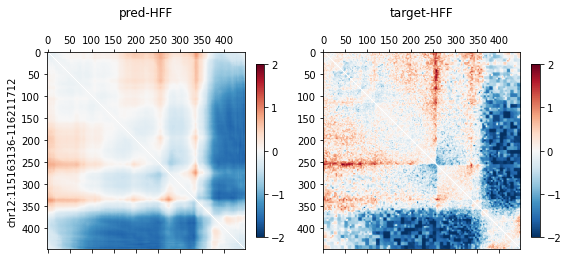

 
chr11:75429888-76478464


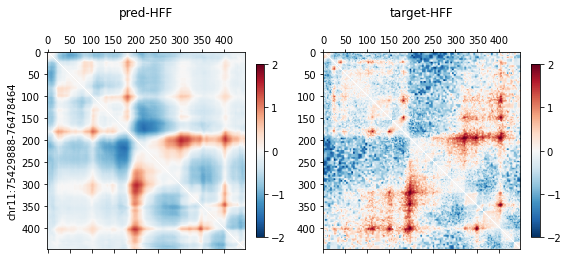

 
chr15:63281152-64329728


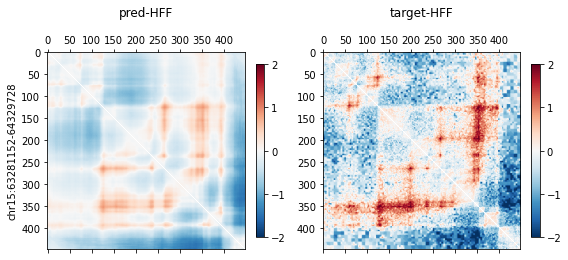

In [19]:
# re-implementation
Core_model = Core(trans_1D=False, trans_2D=False, ATAC_Seq=False)
Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
model = Model(model=Core_model)
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)
model.load_weights("checkpoints/20220502-090312")
model.evaluate(test_dataset)

### make predictions and plot the three examples above ###

target_index = 0 # HFF 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    inputs = test_inputs[test_index:test_index+1,:,:], train_atac_seq[test_index][np.newaxis, :]
    test_pred = model.model.predict(inputs)

    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # plot target 
    plt.subplot(122) 
    mat = from_upper_triu(test_target[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)

    plt.tight_layout()
    plt.show()

103/103 [==============================] - 21s 196ms/step - loss: 0.1416 - PearsonR: 0.5948 - R2: 0.3533
 
chr12:115163136-116211712


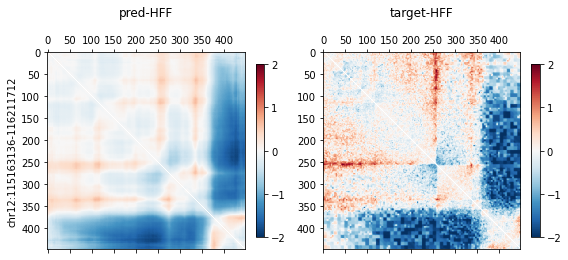

 
chr11:75429888-76478464


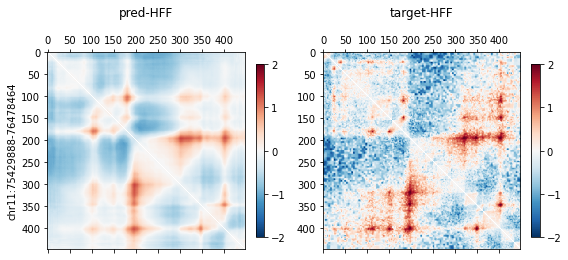

 
chr15:63281152-64329728


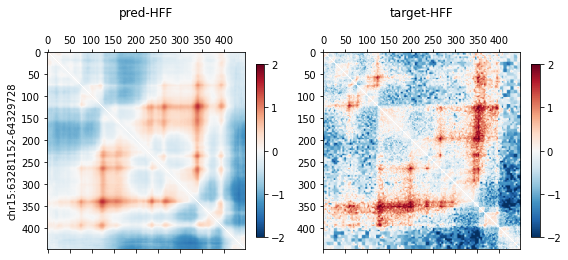

In [20]:
# CNN with ATAC Seq
Core_model = Core(trans_1D=False, trans_2D=False, ATAC_Seq=True)
Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
model = Model(model=Core_model)
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)
model.load_weights("checkpoints/20220501-211604")
model.evaluate(test_dataset)

### make predictions and plot the three examples above ###

target_index = 0 # HFF 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_atac_seq = train_atac_seq[test_index][np.newaxis, :]
    inputs = test_inputs[test_index:test_index+1,:,:].astype(np.float32),  tf.one_hot(test_atac_seq, depth=2)
    test_pred = model.model.predict(inputs)

    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # plot target 
    plt.subplot(122) 
    mat = from_upper_triu(test_target[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)

    plt.tight_layout()
    plt.show()

/home/lichirui/anaconda3/envs/basenji/lib/python3.8/site-packages/keras/engine/training.py:2034: UserWarning: Metric PearsonR implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/lichirui/anaconda3/envs/basenji/lib/python3.8/site-packages/keras/engine/training.py:2034: UserWarning: Metric R2 implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
2022-05-02 18:14:20.211093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-02 18:14:21.432663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 24s 201ms/step - loss: 0.1411 - PearsonR: 0.5979 - R2: 0.3486
 
chr12:115163136-116211712


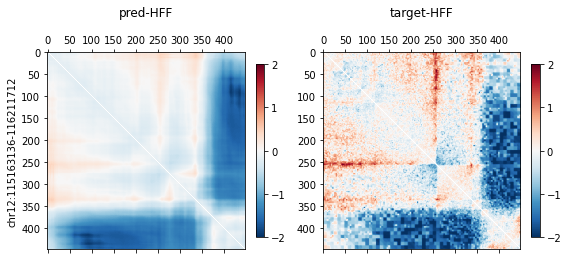

 
chr11:75429888-76478464


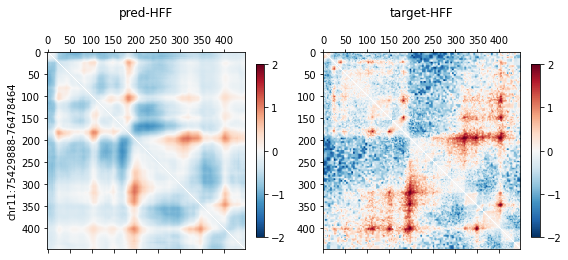

 
chr15:63281152-64329728


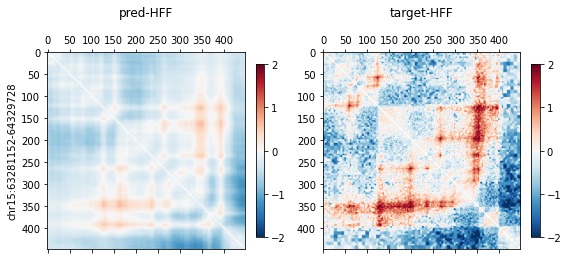

In [19]:
# CNN+Transformer with ATAC Seq
# CNN with ATAC Seq
Core_model = Core(trans_1D=True, trans_2D=False, ATAC_Seq=True)
Core_model.build([(None, 1048576, 4), (None, 1048576, 2)])
model = Model(model=Core_model)
optimizer = tf.keras.optimizers.SGD(0.0065, momentum=0.99575, clipnorm=10.0)
loss_function = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer, loss_function)
model.load_weights("checkpoints/20220501-121443")
model.evaluate(test_dataset)

### make predictions and plot the three examples above ###

target_index = 0 # HFF 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_atac_seq = train_atac_seq[test_index][np.newaxis, :]
    inputs = test_inputs[test_index:test_index+1,:,:].astype(np.float32),  tf.one_hot(test_atac_seq, depth=2)
    test_pred = model.model.predict(inputs)

    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # plot target 
    plt.subplot(122) 
    mat = from_upper_triu(test_target[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)

    plt.tight_layout()
    plt.show()